# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import pycountry
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_enable_multi_backend_download = \
    os.environ.get("RADARCOVID_REPORT__ENABLE_MULTI_BACKEND_DOWNLOAD")
if environment_enable_multi_backend_download:
    report_backend_identifiers = None
else:
    report_backend_identifiers = [report_backend_identifier]

report_backend_identifiers

In [6]:
environment_invalid_shared_diagnoses_dates = \
    os.environ.get("RADARCOVID_REPORT__INVALID_SHARED_DIAGNOSES_DATES")
if environment_invalid_shared_diagnoses_dates:
    invalid_shared_diagnoses_dates = environment_invalid_shared_diagnoses_dates.split(",")
else:
    invalid_shared_diagnoses_dates = []

invalid_shared_diagnoses_dates

['2020-10-30', '2020-12-02', '2020-12-05', '2020-12-19', '2020-12-20']

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe():
    return pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

confirmed_df_ = download_cases_dataframe()
confirmed_df_.iloc[0]

iso_code                                           AFG
continent                                         Asia
location                                   Afghanistan
date                                        2020-02-24
total_cases                                          5
                                              ...     
human_development_index                          0.511
excess_mortality_cumulative_absolute               NaN
excess_mortality_cumulative                        NaN
excess_mortality                                   NaN
excess_mortality_cumulative_per_million            NaN
Name: 0, Length: 67, dtype: object

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["date", "new_cases", "iso_code"]]
confirmed_df.rename(
    columns={
        "date": "sample_date",
        "iso_code": "country_code",
    },
    inplace=True)

def convert_iso_alpha_3_to_alpha_2(x):
    try:
        return pycountry.countries.get(alpha_3=x).alpha_2
    except Exception as e:
        logging.info(f"Error converting country ISO Alpha 3 code '{x}': {repr(e)}")
        return None

confirmed_df["country_code"] = confirmed_df.country_code.apply(convert_iso_alpha_3_to_alpha_2)
confirmed_df.dropna(inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
71801,2021-12-13,9.0,LR
72451,2021-12-13,711.0,LY
25782,2021-12-13,1361.0,CL
27715,2021-12-13,2.0,KM
139836,2021-12-13,0.0,ZW


In [10]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_days_df["sample_date_string"] = \
    confirmed_days_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_days_df.tail()

,sample_date,sample_date_string
687,2021-12-10,2021-12-10
688,2021-12-11,2021-12-11
689,2021-12-12,2021-12-12
690,2021-12-13,2021-12-13
691,2021-12-14,2021-12-14


In [11]:
def sort_source_regions_for_display(source_regions: list) -> list:
    if report_backend_identifier in source_regions:
        source_regions = [report_backend_identifier] + \
            list(sorted(set(source_regions).difference([report_backend_identifier])))
    else:
        source_regions = list(sorted(source_regions))
    return source_regions

In [12]:
report_source_regions = report_backend_client.source_regions_for_date(
    date=extraction_datetime.date())
report_source_regions = sort_source_regions_for_display(
    source_regions=report_source_regions)
report_source_regions

['ES']

In [13]:
def get_cases_dataframe(source_regions_for_date_function, columns_suffix=None):
    source_regions_at_date_df = confirmed_days_df.copy()
    source_regions_at_date_df["source_regions_at_date"] = \
        source_regions_at_date_df.sample_date.apply(
            lambda x: source_regions_for_date_function(date=x))
    source_regions_at_date_df.sort_values("sample_date", inplace=True)
    source_regions_at_date_df["_source_regions_group"] = source_regions_at_date_df. \
        source_regions_at_date.apply(lambda x: ",".join(sort_source_regions_for_display(x)))
    source_regions_at_date_df.tail()

    #%%

    source_regions_for_summary_df_ = \
        source_regions_at_date_df[["sample_date", "_source_regions_group"]].copy()
    source_regions_for_summary_df_.rename(columns={"_source_regions_group": "source_regions"}, inplace=True)
    source_regions_for_summary_df_.tail()

    #%%

    confirmed_output_columns = ["sample_date", "new_cases", "covid_cases"]
    confirmed_output_df = pd.DataFrame(columns=confirmed_output_columns)

    for source_regions_group, source_regions_group_series in \
            source_regions_at_date_df.groupby("_source_regions_group"):
        source_regions_set = set(source_regions_group.split(","))
        confirmed_source_regions_set_df = \
            confirmed_df[confirmed_df.country_code.isin(source_regions_set)].copy()
        confirmed_source_regions_group_df = \
            confirmed_source_regions_set_df.groupby("sample_date").new_cases.sum() \
                .reset_index().sort_values("sample_date")
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df.merge(
                confirmed_days_df[["sample_date_string"]].rename(
                    columns={"sample_date_string": "sample_date"}),
                how="right")
        confirmed_source_regions_group_df["new_cases"] = \
            confirmed_source_regions_group_df["new_cases"].clip(lower=0)
        confirmed_source_regions_group_df["covid_cases"] = \
            confirmed_source_regions_group_df.new_cases.rolling(7, min_periods=0).mean().round()
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df[confirmed_output_columns]
        confirmed_source_regions_group_df = confirmed_source_regions_group_df.replace(0, np.nan)
        confirmed_source_regions_group_df.fillna(method="ffill", inplace=True)
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df[
                confirmed_source_regions_group_df.sample_date.isin(
                    source_regions_group_series.sample_date_string)]
        confirmed_output_df = confirmed_output_df.append(confirmed_source_regions_group_df)

    result_df = confirmed_output_df.copy()
    result_df.tail()

    #%%

    result_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
    result_df = confirmed_days_df[["sample_date_string"]].merge(result_df, how="left")
    result_df.sort_values("sample_date_string", inplace=True)
    result_df.fillna(method="ffill", inplace=True)
    result_df.tail()

    #%%

    result_df[["new_cases", "covid_cases"]].plot()

    if columns_suffix:
        result_df.rename(
            columns={
                "new_cases": "new_cases_" + columns_suffix,
                "covid_cases": "covid_cases_" + columns_suffix},
            inplace=True)
    return result_df, source_regions_for_summary_df_

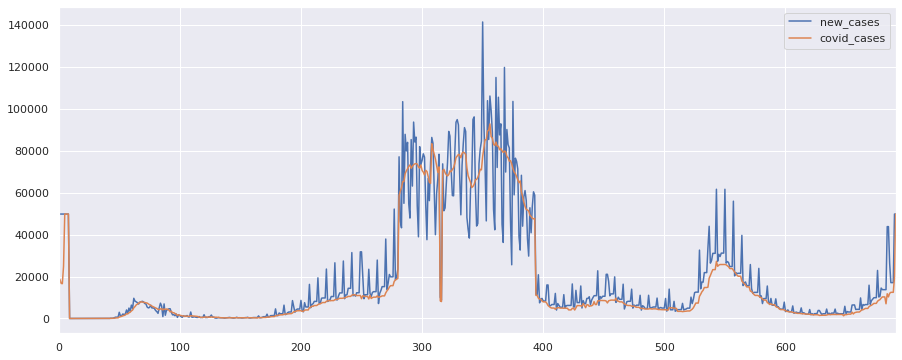

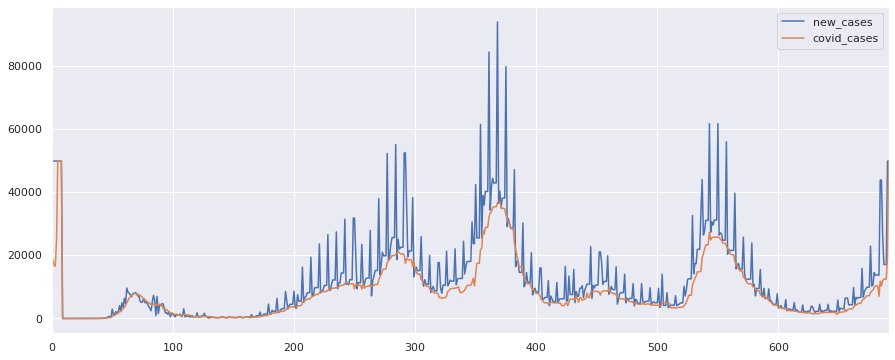

In [14]:
confirmed_eu_df, source_regions_for_summary_df = get_cases_dataframe(
    report_backend_client.source_regions_for_date)
confirmed_es_df, _ = get_cases_dataframe(
    lambda date: [spain_region_country_code],
    columns_suffix=spain_region_country_code.lower())

### Extract API TEKs

In [15]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
base_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=base_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/socket.py", line 918, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -2] Name or service not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connection

Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connectionpool.py", line 381, in _make_request
    self._validate_conn(conn)
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connectionpool.py", line 978, in _validate_conn
    conn.connect()
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/connection.py", line 362, in connect
    self.sock = ssl_wrap_socket(
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/urllib3/util/ssl_.py", line 386, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2021-12-10,2021-12-10,ES,V1,214,1.2.840.10045.4.3.2,6905e5e4-90d1-4a95-c47e-45d77f24e62f,2731824,111,0,ES
1,2021-12-07,2021-12-07,ES,V1,214,1.2.840.10045.4.3.2,6815edbd-953e-3c10-947a-f52bbf3e9c3f,2731392,144,0,ES
2,2021-12-10,2021-12-10,ES,V1,214,1.2.840.10045.4.3.2,6aceb513-cb43-b1ff-2534-ca4c38bcfc69,2731824,115,0,ES
3,2021-12-13,2021-12-13,ES,V1,214,1.2.840.10045.4.3.2,a99c6ada-9ca4-cc65-a628-1eddfb5d5f0e,2732256,86,0,ES
4,2021-12-01,2021-12-01,ES,V1,214,1.2.840.10045.4.3.2,c9b106e6-6466-faf9-9511-614935142b1e,2730528,144,0,ES


<AxesSubplot:>

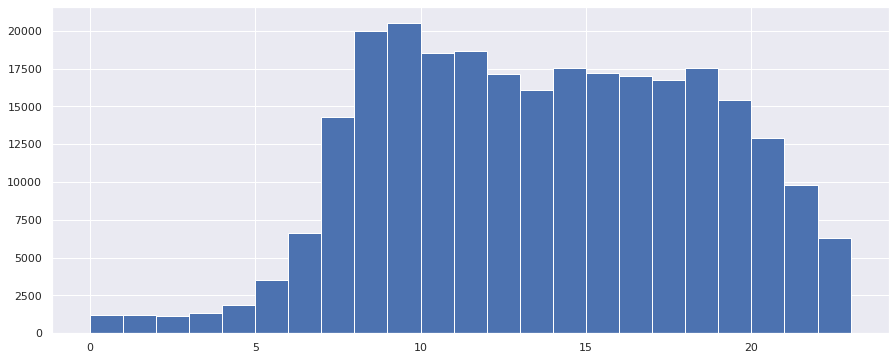

In [16]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

<AxesSubplot:>

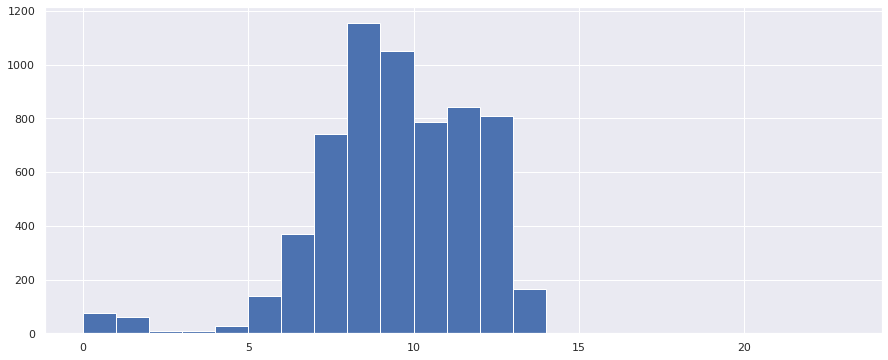

In [17]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [18]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2021-12-10,ES,6905e5e4-90d1-4a95-c47e-45d77f24e62f
1,2021-12-07,ES,6815edbd-953e-3c10-947a-f52bbf3e9c3f
2,2021-12-10,ES,6aceb513-cb43-b1ff-2534-ca4c38bcfc69
3,2021-12-13,ES,a99c6ada-9ca4-cc65-a628-1eddfb5d5f0e
4,2021-12-01,ES,c9b106e6-6466-faf9-9511-614935142b1e


In [19]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'IT@ES', 'ES', 'CH', 'MT', 'DE@ES', 'EU@ES', 'DE']

In [20]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                \
region                                  CH     DE  DE@ES  EE   ES  EU@ES   
sample_date                                                                
2021-12-14                             221      0     56   6  111    191   
2021-12-13                             538   5113   4676  13  438   7035   
2021-12-12                             738   7903   5664  22  325   9854   
2021-12-11                             981  14761  11194  27  452  17375   
2021-12-10                            1214  22914  17822  25  593  26175   

                         
region      IT@ES    MT  
sample_date              
2021-12-14      0  5652  
2021-12-13      0  5920  
2021-12-12     58  6257  
2021-12-11    189  6241  
2021-12-10    243  6332

In [21]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

/tmp/ipykernel_1927/4280397781.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
/tmp/ipykernel_1927/4280397781.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


/tmp/ipykernel_1927/4280397781.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                         \
region_x                   CH        DE     DE@ES       EE        ES   
region_y                                                               
CH                        NaN  0.028696  0.000000  0.00000  0.000000   
DE                   0.904558       NaN  0.995080  0.00000  0.758812   
DE@ES                0.000000  0.661794       NaN  0.00000  0.000000   
EE                   0.000000  0.000000  0.000000      NaN  0.000000   
ES                   0.000000  0.008712  0.000000  0.00000       NaN   
EU@ES                0.000000  0.761384  1.000000  0.47929  1.000000   
IT@ES                0.000000  0.000045  0.000000  0.00000  0.000000   
MT                   0.000000  0.048389  0.068978  0.00000  0.124172   

                                        
region_x     EU@ES     IT@ES        MT  
region_y                                
CH        0.000000  0.000000  0.000000  
DE        0.796103  0.004446  0.246753  
DE@ES     0.695393  0.000000  0.233932  
EE        0.000348  0.000000  0.000000  
ES        0.012004  0.000000  0.007269  
EU@ES          NaN  1.000000  0.382987  
IT@ES     0.010627       NaN  0.002137  
MT        0.078530  0.041229       NaN

In [22]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['EE', 'IT@ES', 'CH', 'MT', 'DE@ES', 'EU@ES', 'DE']

In [23]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2021-12-14,111
2021-12-13,438
2021-12-12,325
2021-12-11,452
2021-12-10,593


### Dump API TEKs

In [24]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_base_df = tek_list_df[tek_list_df.region == report_backend_identifier]
tek_list_base_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_base_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_base_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_base_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
4,2021-12-01,ES,"[c9b106e6-6466-faf9-9511-614935142b1e, 7510407...",2021-12-14,2021-12-14@16
12,2021-12-02,ES,"[935188e4-af91-4d20-ca00-92a4dc675eb2, 43c7d94...",2021-12-14,2021-12-14@16
20,2021-12-03,ES,"[717284c8-3287-d0e9-ec4f-ad748b7e2aa3, 7637e7d...",2021-12-14,2021-12-14@16
28,2021-12-04,ES,"[739e3e56-1291-f45c-eaa6-6087a5b5f655, 45d6668...",2021-12-14,2021-12-14@16
36,2021-12-05,ES,"[7401fec0-2f8f-ec26-8fcd-4e9c3a8161b2, e19d6c3...",2021-12-14,2021-12-14@16


### Load TEK Dumps

In [25]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [26]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
0,ES,2021-12-01,"[c9b106e6-6466-faf9-9511-614935142b1e, 7510407...",2021-12-14
1,ES,2021-12-02,"[935188e4-af91-4d20-ca00-92a4dc675eb2, 43c7d94...",2021-12-14
2,ES,2021-12-03,"[717284c8-3287-d0e9-ec4f-ad748b7e2aa3, 7637e7d...",2021-12-14
3,ES,2021-12-04,"[739e3e56-1291-f45c-eaa6-6087a5b5f655, 45d6668...",2021-12-14
4,ES,2021-12-05,"[7401fec0-2f8f-ec26-8fcd-4e9c3a8161b2, e19d6c3...",2021-12-14


In [27]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2021-12-14,111
2021-12-13,438
2021-12-12,325
2021-12-11,452
2021-12-10,593


### Daily New TEKs

In [28]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2021-09-21,"{31ebc002-e26a-a846-c04d-82fad861c1c7, 7c2d82f..."
2021-09-22,"{31ebc002-e26a-a846-c04d-82fad861c1c7, 7c2d82f..."
2021-09-23,"{7c2d82f1-0d71-0a19-edb3-d00e2e72128c, 7cef45e..."
2021-09-24,"{7c2d82f1-0d71-0a19-edb3-d00e2e72128c, 7cef45e..."
2021-09-25,"{7cef45ee-4bc4-46a2-9b28-67931624e81c, 536672a..."


In [29]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

/tmp/ipykernel_1927/1873217990.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
7,2021-09-22,2021-09-16,4,6
6,2021-09-22,2021-09-15,4,7
5,2021-09-22,2021-09-14,2,8
4,2021-09-22,2021-09-13,1,9
3,2021-09-22,2021-09-12,1,10


In [30]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
7,2021-12-14,2021-12-08,19,6
6,2021-12-14,2021-12-07,11,7
5,2021-12-14,2021-12-06,8,8
4,2021-12-14,2021-12-05,4,9
3,2021-12-14,2021-12-04,3,10


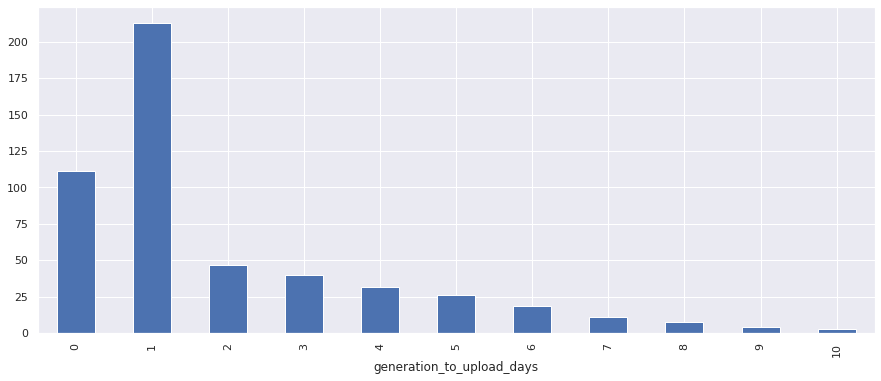

In [31]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [32]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2021-12-14,111,213,47,40,32,26,19,11,8,4,3,0,0,0
2021-12-13,225,133,109,97,88,69,45,25,17,11,5,0,0,0
2021-12-12,145,96,60,54,44,33,21,11,3,2,2,0,0,0
2021-12-11,207,125,85,76,66,45,32,17,11,6,4,0,0,0
2021-12-10,279,272,119,109,94,65,44,25,18,11,8,1,0,0


In [33]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
80,2021-12-10,1045.0
81,2021-12-11,674.0
82,2021-12-12,471.0
83,2021-12-13,824.0
84,2021-12-14,514.0


In [34]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
13,2021-12-14,111
13,2021-12-13,225
13,2021-12-12,145
13,2021-12-11,207
13,2021-12-10,279


In [35]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df \
    .groupby(["upload_date"]).shared_teks.max().reset_index() \
    .sort_values(["upload_date"], ascending=False) \
    .rename(columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
invalid_shared_diagnoses_dates_mask = \
    estimated_shared_diagnoses_df.sample_date_string.isin(invalid_shared_diagnoses_dates)
estimated_shared_diagnoses_df[invalid_shared_diagnoses_dates_mask] = 0
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
83,2021-12-14,213
82,2021-12-13,225
81,2021-12-12,145
80,2021-12-11,207
79,2021-12-10,279


### Hourly New TEKs

In [36]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,ES,2021-12-01,"[c9b106e6-6466-faf9-9511-614935142b1e, 7510407...",2021-12-14,2021-12-14@16
1,ES,2021-12-02,"[935188e4-af91-4d20-ca00-92a4dc675eb2, 43c7d94...",2021-12-14,2021-12-14@16
2,ES,2021-12-03,"[717284c8-3287-d0e9-ec4f-ad748b7e2aa3, 7637e7d...",2021-12-14,2021-12-14@16
3,ES,2021-12-04,"[739e3e56-1291-f45c-eaa6-6087a5b5f655, 45d6668...",2021-12-14,2021-12-14@16
4,ES,2021-12-05,"[7401fec0-2f8f-ec26-8fcd-4e9c3a8161b2, e19d6c3...",2021-12-14,2021-12-14@16


In [37]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2021-12-13@16,0
1,2021-12-13@17,0
2,2021-12-13@18,38
3,2021-12-13@19,0
4,2021-12-13@20,178


In [38]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2021-12-13 17:00:00,2021-12-13@17,0
2021-12-13 18:00:00,2021-12-13@18,38
2021-12-13 19:00:00,2021-12-13@19,0
2021-12-13 20:00:00,2021-12-13@20,178
2021-12-13 21:00:00,2021-12-13@21,0


### Official Statistics

In [39]:
import requests
import pandas.io.json

official_stats_response = requests.get("https://radarcovid.covid19.gob.es/kpi/statistics/basics")
official_stats_response.raise_for_status()
official_stats_df_ = pandas.io.json.json_normalize(official_stats_response.json())

In [40]:
official_stats_df = official_stats_df_.copy()
official_stats_df["date"] = pd.to_datetime(official_stats_df["date"], dayfirst=True)
official_stats_df.head()

,date,applicationsDownloads.totalActualDay,applicationsDownloads.totalAcummulated,communicatedContagions.totalActualDay,communicatedContagions.totalAcummulated
0,2021-12-05,0,8117262,0,78702


In [41]:
official_stats_column_map = {
    "date": "sample_date",
    "applicationsDownloads.totalAcummulated": "app_downloads_es_accumulated",
    "communicatedContagions.totalAcummulated": "shared_diagnoses_es_accumulated",
}
accumulated_suffix = "_accumulated"
accumulated_values_columns = \
    list(filter(lambda x: x.endswith(accumulated_suffix), official_stats_column_map.values()))
interpolated_values_columns = \
    list(map(lambda x: x[:-len(accumulated_suffix)], accumulated_values_columns))

In [42]:
official_stats_df = \
    official_stats_df[official_stats_column_map.keys()] \
        .rename(columns=official_stats_column_map)
official_stats_df["extraction_date"] = extraction_date
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-12-05,8117262,78702,2021-12-14


In [43]:
official_stats_path = "Data/Statistics/Current/RadarCOVID-Statistics.json"
previous_official_stats_df = pd.read_json(official_stats_path, orient="records", lines=True)
previous_official_stats_df["sample_date"] = pd.to_datetime(previous_official_stats_df["sample_date"], dayfirst=True)
official_stats_df = official_stats_df.append(previous_official_stats_df)
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-12-05,8117262,78702,2021-12-14
0,2021-12-05,8117262,78702,2021-12-14
1,2021-11-28,8077166,77636,2021-12-09
2,2021-11-21,8049115,77061,2021-12-01
3,2021-11-14,8030255,76657,2021-11-24


In [44]:
official_stats_df = official_stats_df[~(official_stats_df.shared_diagnoses_es_accumulated == 0)]
official_stats_df.sort_values("extraction_date", ascending=False, inplace=True)
official_stats_df.drop_duplicates(subset=["sample_date"], keep="first", inplace=True)
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-12-05,8117262,78702,2021-12-14
1,2021-11-28,8077166,77636,2021-12-09
2,2021-11-21,8049115,77061,2021-12-01
3,2021-11-14,8030255,76657,2021-11-24
4,2021-11-07,8009798,76421,2021-11-18


In [45]:
official_stats_stored_df = official_stats_df.copy()
official_stats_stored_df["sample_date"] = official_stats_stored_df.sample_date.dt.strftime("%Y-%m-%d")
official_stats_stored_df.to_json(official_stats_path, orient="records", lines=True)

In [46]:
official_stats_df.drop(columns=["extraction_date"], inplace=True)
official_stats_df = confirmed_days_df.merge(official_stats_df, how="left")
official_stats_df.sort_values("sample_date", ascending=False, inplace=True)
official_stats_df.head()

,sample_date,sample_date_string,app_downloads_es_accumulated,shared_diagnoses_es_accumulated
691,2021-12-14,2021-12-14,NaN,NaN
690,2021-12-13,2021-12-13,NaN,NaN
689,2021-12-12,2021-12-12,NaN,NaN
688,2021-12-11,2021-12-11,NaN,NaN
687,2021-12-10,2021-12-10,NaN,NaN


In [47]:
official_stats_df[accumulated_values_columns] = \
    official_stats_df[accumulated_values_columns] \
        .astype(float).interpolate(limit_area="inside")
official_stats_df[interpolated_values_columns] = \
    official_stats_df[accumulated_values_columns].diff(periods=-1)
official_stats_df.drop(columns="sample_date", inplace=True)
official_stats_df.head()

,sample_date_string,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
691,2021-12-14,NaN,NaN,NaN,NaN
690,2021-12-13,NaN,NaN,NaN,NaN
689,2021-12-12,NaN,NaN,NaN,NaN
688,2021-12-11,NaN,NaN,NaN,NaN
687,2021-12-10,NaN,NaN,NaN,NaN


### Data Merge

In [48]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2021-12-14,111,514.0
1,2021-12-13,438,824.0
2,2021-12-12,325,471.0
3,2021-12-11,452,674.0
4,2021-12-10,593,1045.0


In [49]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2021-12-14,111,514.0,111.0
1,2021-12-13,438,824.0,225.0
2,2021-12-12,325,471.0,145.0
3,2021-12-11,452,674.0,207.0
4,2021-12-10,593,1045.0,279.0


In [50]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2021-12-14,111,514.0,111.0,213.0
1,2021-12-13,438,824.0,225.0,225.0
2,2021-12-12,325,471.0,145.0,145.0
3,2021-12-11,452,674.0,207.0,207.0
4,2021-12-10,593,1045.0,279.0,279.0


In [51]:
result_summary_df = result_summary_df.merge(
    official_stats_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2021-12-14,111.0,514.0,111.0,213.0,NaN,NaN,NaN,NaN
1,2021-12-13,438.0,824.0,225.0,225.0,NaN,NaN,NaN,NaN
2,2021-12-12,325.0,471.0,145.0,145.0,NaN,NaN,NaN,NaN
3,2021-12-11,452.0,674.0,207.0,207.0,NaN,NaN,NaN,NaN
4,2021-12-10,593.0,1045.0,279.0,279.0,NaN,NaN,NaN,NaN


In [52]:
result_summary_df = confirmed_eu_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2021-09-22,2840.0,2654.0,7.0,68.0,22.0,22.0,7.871103e+06,75717.571429,2278.571429,15.857143
1,2021-09-23,3031.0,2504.0,7.0,71.0,18.0,18.0,7.873381e+06,75733.428571,2278.571429,15.857143
2,2021-09-24,2746.0,2436.0,8.0,56.0,14.0,14.0,7.875660e+06,75749.285714,2278.571429,15.857143
3,2021-09-25,2746.0,2436.0,12.0,17.0,7.0,7.0,7.877938e+06,75765.142857,2278.571429,15.857143
4,2021-09-26,2746.0,2436.0,11.0,15.0,8.0,8.0,7.880217e+06,75781.000000,2278.571429,15.857143


In [53]:
result_summary_df = confirmed_es_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2021-09-22,2840.0,2654.0,2840.0,2654.0,7.0,68.0,22.0,22.0,7.871103e+06,75717.571429,2278.571429,15.857143
1,2021-09-23,3031.0,2504.0,3031.0,2504.0,7.0,71.0,18.0,18.0,7.873381e+06,75733.428571,2278.571429,15.857143
2,2021-09-24,2746.0,2436.0,2746.0,2436.0,8.0,56.0,14.0,14.0,7.875660e+06,75749.285714,2278.571429,15.857143
3,2021-09-25,2746.0,2436.0,2746.0,2436.0,12.0,17.0,7.0,7.0,7.877938e+06,75765.142857,2278.571429,15.857143
4,2021-09-26,2746.0,2436.0,2746.0,2436.0,11.0,15.0,8.0,8.0,7.880217e+06,75781.000000,2278.571429,15.857143


In [54]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df = result_summary_df.merge(source_regions_for_summary_df, how="left")
result_summary_df.set_index(["sample_date", "source_regions"], inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
sample_date,source_regions,,,,,,,,,,,,
2021-12-14,ES,49802.0,49802.0,49802.0,49802.0,111.0,514.0,111.0,213.0,NaN,NaN,NaN,NaN
2021-12-13,ES,49802.0,19588.0,49802.0,19588.0,438.0,824.0,225.0,225.0,NaN,NaN,NaN,NaN
2021-12-12,ES,17095.0,12474.0,17095.0,12474.0,325.0,471.0,145.0,145.0,NaN,NaN,NaN,NaN
2021-12-11,ES,17095.0,12474.0,17095.0,12474.0,452.0,674.0,207.0,207.0,NaN,NaN,NaN,NaN
2021-12-10,ES,17095.0,12474.0,17095.0,12474.0,593.0,1045.0,279.0,279.0,NaN,NaN,NaN,NaN


In [55]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case_es"] = \
        (result_summary_df.shared_diagnoses_es / result_summary_df.covid_cases_es).fillna(0)

result_summary_df.head(daily_plot_days)

,,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case,shared_diagnoses_per_covid_case_es
sample_date,source_regions,,,,,,,,,,,,,,,
2021-12-14,ES,49802,49802,49802,49802,111,514,111,213,0,0,0,0,2.413146,0.004277,0.000000
2021-12-13,ES,49802,19588,49802,19588,438,824,225,225,0,0,0,0,3.662222,0.011487,0.000000
2021-12-12,ES,17095,12474,17095,12474,325,471,145,145,0,0,0,0,3.248276,0.011624,0.000000
2021-12-11,ES,17095,12474,17095,12474,452,674,207,207,0,0,0,0,3.256039,0.016595,0.000000
2021-12-10,ES,17095,12474,17095,12474,593,1045,279,279,0,0,0,0,3.745520,0.022367,0.000000
2021-12-09,ES,26412,11994,26412,11994,684,677,159,159,0,0,0,0,4.257862,0.013257,0.000000
2021-12-08,ES,43808,10292,43808,10292,574,488,141,141,0,0,0,0,3.460993,0.013700,0.000000
2021-12-07,ES,43808,11797,43808,11797,561,389,123,123,0,0,0,0,3.162602,0.010426,0.000000
2021-12-06,ES,13738,7005,13738,7005,489,292,91,91,0,0,0,0,3.208791,0.012991,0.000000


In [56]:
def compute_aggregated_results_summary(days) -> pd.DataFrame:
    aggregated_result_summary_df = result_summary_df.copy()
    aggregated_result_summary_df["covid_cases_for_ratio"] = \
        aggregated_result_summary_df.covid_cases.mask(
            aggregated_result_summary_df.shared_diagnoses == 0, 0)
    aggregated_result_summary_df["covid_cases_for_ratio_es"] = \
        aggregated_result_summary_df.covid_cases_es.mask(
            aggregated_result_summary_df.shared_diagnoses_es == 0, 0)
    aggregated_result_summary_df = aggregated_result_summary_df \
        .sort_index(ascending=True).fillna(0).rolling(days).agg({
        "covid_cases": "sum",
        "covid_cases_es": "sum",
        "covid_cases_for_ratio": "sum",
        "covid_cases_for_ratio_es": "sum",
        "shared_teks_by_generation_date": "sum",
        "shared_teks_by_upload_date": "sum",
        "shared_diagnoses": "sum",
        "shared_diagnoses_es": "sum",
    }).sort_index(ascending=False)

    with pd.option_context("mode.use_inf_as_na", True):
        aggregated_result_summary_df = aggregated_result_summary_df.fillna(0).astype(int)
        aggregated_result_summary_df["teks_per_shared_diagnosis"] = \
            (aggregated_result_summary_df.shared_teks_by_upload_date /
             aggregated_result_summary_df.covid_cases_for_ratio).fillna(0)
        aggregated_result_summary_df["shared_diagnoses_per_covid_case"] = \
            (aggregated_result_summary_df.shared_diagnoses /
             aggregated_result_summary_df.covid_cases_for_ratio).fillna(0)
        aggregated_result_summary_df["shared_diagnoses_per_covid_case_es"] = \
            (aggregated_result_summary_df.shared_diagnoses_es /
             aggregated_result_summary_df.covid_cases_for_ratio_es).fillna(0)

    return aggregated_result_summary_df

In [57]:
aggregated_result_with_7_days_window_summary_df = compute_aggregated_results_summary(days=7)
aggregated_result_with_7_days_window_summary_df.head()

,,covid_cases,covid_cases_es,covid_cases_for_ratio,covid_cases_for_ratio_es,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,shared_diagnoses_es,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case,shared_diagnoses_per_covid_case_es
sample_date,source_regions,,,,,,,,,,,
2021-12-14,ES,129098,129098,129098,0,3177,4693,1369,0,0.036352,0.010604,0.000000
2021-12-13,ES,91093,91093,91093,0,3627,4568,1279,0,0.050147,0.014041,0.000000
2021-12-12,ES,78510,78510,78510,0,3678,4036,1145,0,0.051407,0.014584,0.000000
2021-12-11,ES,76314,76314,76314,10278,3811,3853,1095,152,0.050489,0.014349,0.014789
2021-12-10,ES,74118,74118,74118,20556,3700,3600,1009,304,0.048571,0.013613,0.014789


In [58]:
last_7_days_summary = aggregated_result_with_7_days_window_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 91093,
 'covid_cases_es': 91093,
 'covid_cases_for_ratio': 91093,
 'covid_cases_for_ratio_es': 0,
 'shared_teks_by_generation_date': 3627,
 'shared_teks_by_upload_date': 4568,
 'shared_diagnoses': 1279,
 'shared_diagnoses_es': 0,
 'teks_per_shared_diagnosis': 0.05014655352222454,
 'shared_diagnoses_per_covid_case': 0.014040595874545795,
 'shared_diagnoses_per_covid_case_es': 0.0}

In [59]:
aggregated_result_with_14_days_window_summary_df = compute_aggregated_results_summary(days=13)
last_14_days_summary = aggregated_result_with_14_days_window_summary_df.to_dict(orient="records")[1]
last_14_days_summary

{'covid_cases': 147646,
 'covid_cases_es': 147646,
 'covid_cases_for_ratio': 147646,
 'covid_cases_for_ratio_es': 49548,
 'shared_teks_by_generation_date': 5478,
 'shared_teks_by_upload_date': 7093,
 'shared_diagnoses': 2036,
 'shared_diagnoses_es': 760,
 'teks_per_shared_diagnosis': 0.04804058355796974,
 'shared_diagnoses_per_covid_case': 0.013789740324831015,
 'shared_diagnoses_per_covid_case_es': 0.015338661499959634}

## Report Results

In [60]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "source_regions": "Source Countries",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases (Source Countries)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date (Source Countries)",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date (Source Countries)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date (Source Countries)",
    "shared_diagnoses": "Shared Diagnoses (Source Countries – Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis (Source Countries)",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Source Countries)",

    "covid_cases_es": "COVID-19 Cases (Spain)",
    "app_downloads_es": "App Downloads (Spain – Official)",
    "shared_diagnoses_es": "Shared Diagnoses (Spain – Official)",
    "shared_diagnoses_per_covid_case_es": "Usage Ratio (Spain)",
}

In [61]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",

    "covid_cases_es",
    "app_downloads_es",
    "shared_diagnoses_es",
    "shared_diagnoses_per_covid_case_es",
]

summary_percentage_columns= [
    "shared_diagnoses_per_covid_case_es",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [62]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,,COVID-19 Cases (Source Countries),Shared TEKs by Generation Date (Source Countries),Shared TEKs by Upload Date (Source Countries),Shared TEKs Uploaded on Generation Date (Source Countries),Shared Diagnoses (Source Countries – Estimation),TEKs Uploaded per Shared Diagnosis (Source Countries),Usage Ratio (Source Countries),COVID-19 Cases (Spain),App Downloads (Spain – Official),Shared Diagnoses (Spain – Official),Usage Ratio (Spain)
Sample Date (UTC),Source Countries,,,,,,,,,,,
2021-12-14,ES,49802,111,514,111,213,2.413146,0.004277,49802,0,0,0.000000
2021-12-13,ES,19588,438,824,225,225,3.662222,0.011487,19588,0,0,0.000000
2021-12-12,ES,12474,325,471,145,145,3.248276,0.011624,12474,0,0,0.000000
2021-12-11,ES,12474,452,674,207,207,3.256039,0.016595,12474,0,0,0.000000
2021-12-10,ES,12474,593,1045,279,279,3.745520,0.022367,12474,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,ES,2436,11,15,8,8,1.875000,0.003284,2436,2278,15,0.006158
2021-09-25,ES,2436,12,17,7,7,2.428571,0.002874,2436,2278,15,0.006158
2021-09-24,ES,2436,8,56,14,14,4.000000,0.005747,2436,2278,15,0.006158


### Daily Summary Plots

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

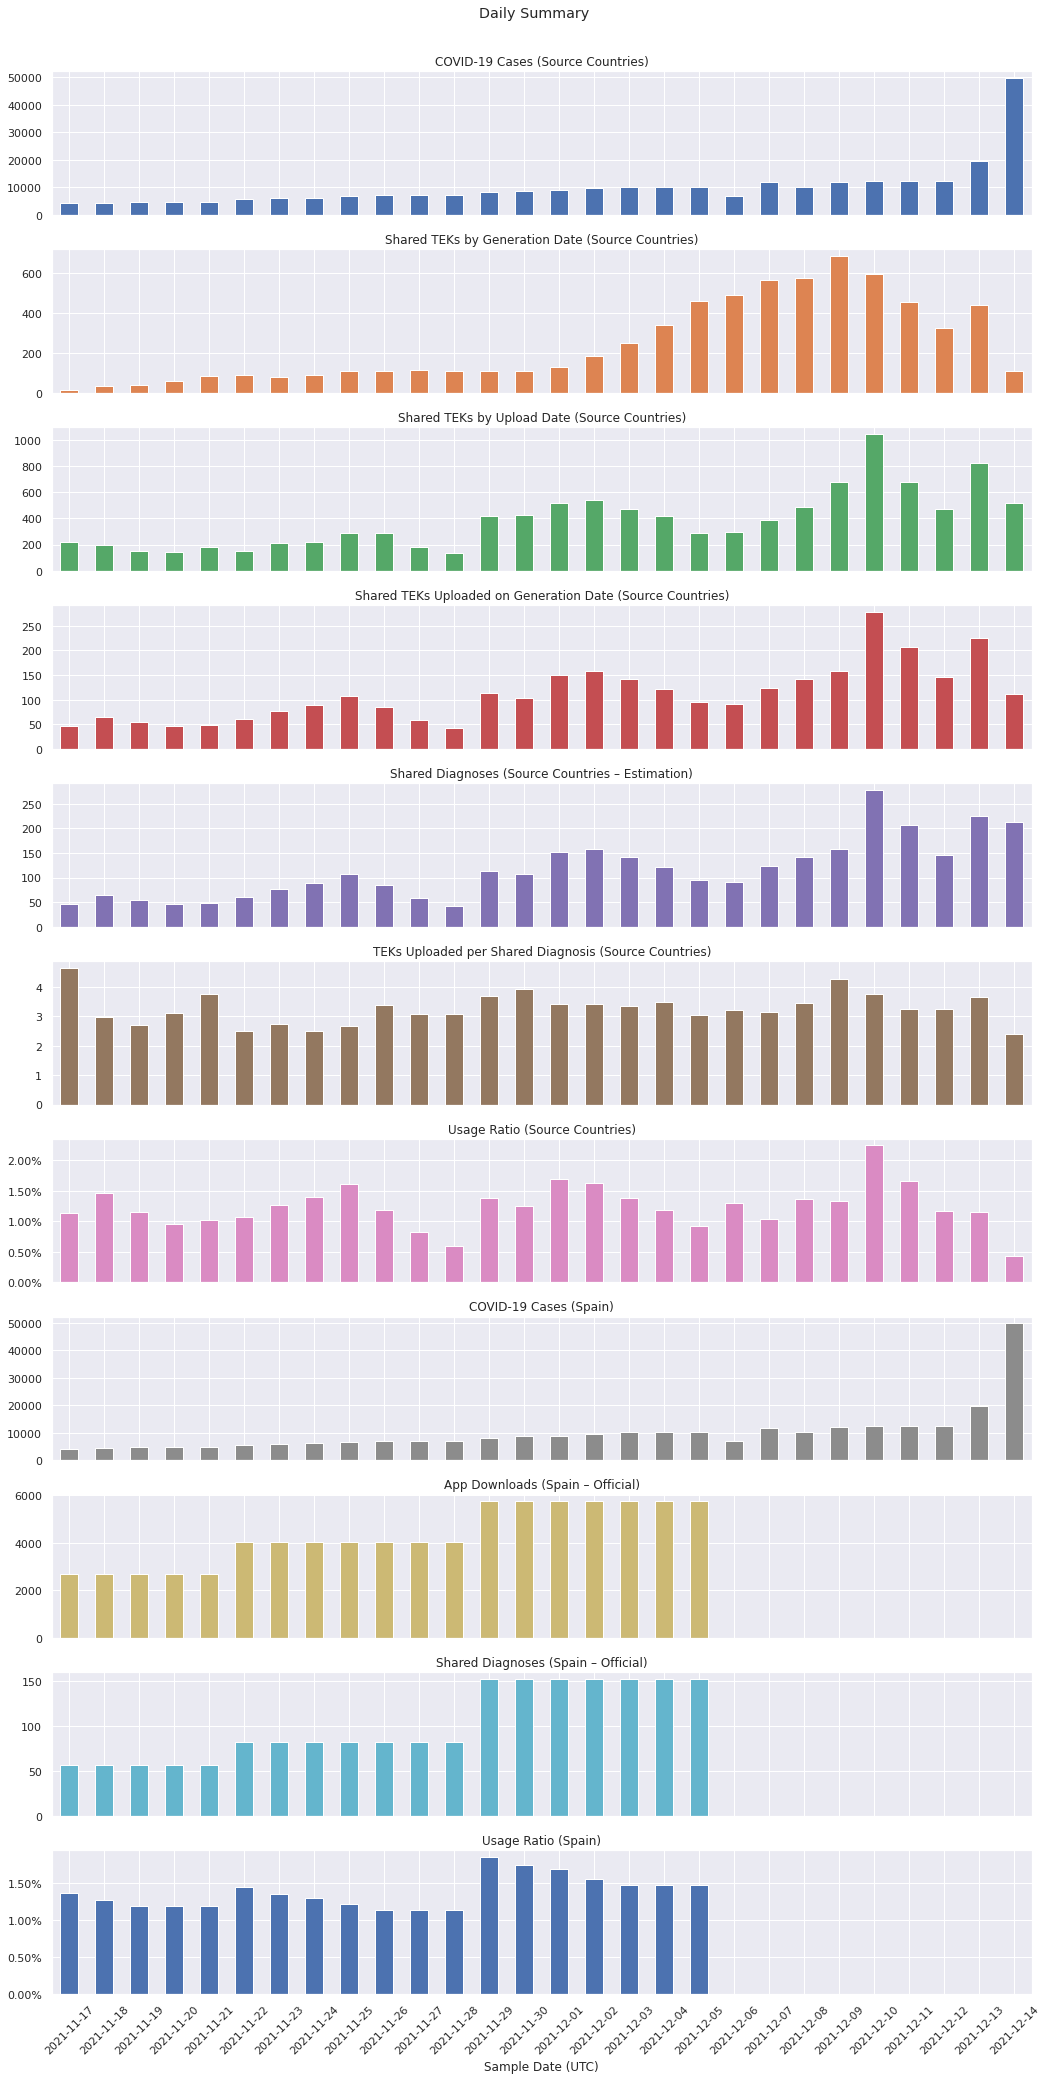

In [63]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .droplevel(level=["source_regions"]) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 30), legend=False)
ax_ = summary_ax_list[0]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

for percentage_column in summary_percentage_columns:
    percentage_column_index = summary_columns.index(percentage_column)
    summary_ax_list[percentage_column_index].yaxis \
        .set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

### Daily Generation to Upload Period Table

In [64]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2021-12-14,111,213,47,40,32,26,19,11,8,4,3,0,0,0
2021-12-13,225,133,109,97,88,69,45,25,17,11,5,0,0,0
2021-12-12,145,96,60,54,44,33,21,11,3,2,2,0,0,0
2021-12-11,207,125,85,76,66,45,32,17,11,6,4,0,0,0
2021-12-10,279,272,119,109,94,65,44,25,18,11,8,1,0,0
2021-12-09,159,106,89,78,68,54,42,33,23,16,9,0,0,0
2021-12-08,141,85,66,64,50,43,20,16,3,0,0,0,0,0
2021-12-07,123,61,51,45,39,34,18,9,6,2,1,0,0,0
2021-12-06,91,51,40,35,25,21,15,6,3,2,3,0,0,0


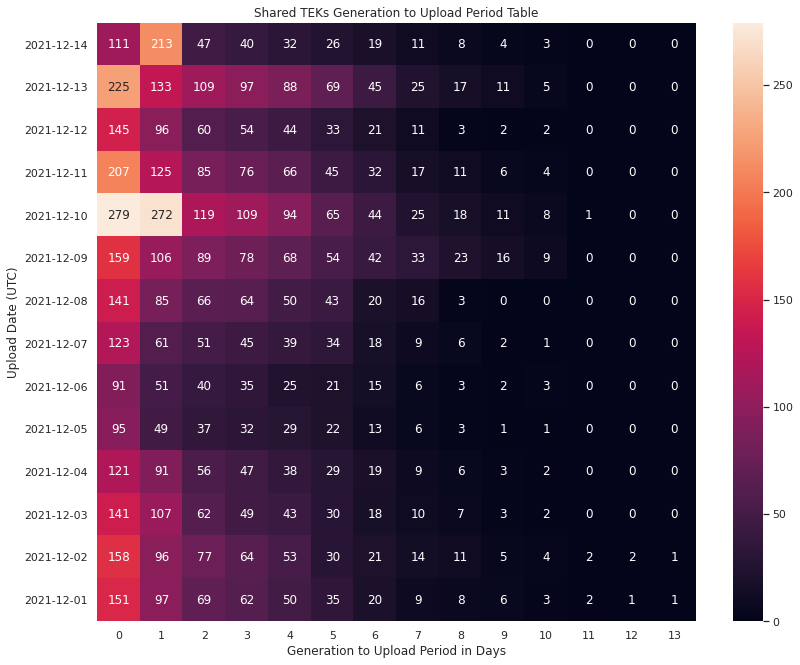

In [65]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(12, 1 + 0.6 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

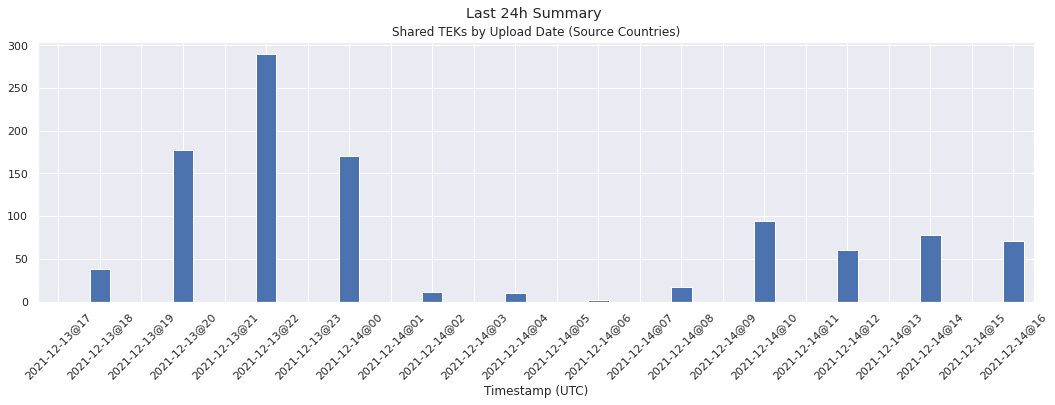

In [66]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [67]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}" if x != 0 else "",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}" if x != 0 else "",
    display_column_name_mapping["shared_diagnoses_per_covid_case_es"]: lambda x: f"{x:.2%}" if x != 0 else "",
}
general_columns = \
    list(filter(lambda x: x not in display_formatters, display_column_name_mapping.values()))
general_formatter = lambda x: f"{x}" if x != 0 else ""
display_formatters.update(dict(map(lambda x: (x, general_formatter), general_columns)))

daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index.get_level_values("sample_date") == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.item()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.item()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.item()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.item()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.item()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)
if len(report_source_regions) == 1:
    display_brief_source_regions = report_source_regions[0]
else:
    display_brief_source_regions = f"{len(report_source_regions)} 🇪🇺"

/tmp/ipykernel_1927/1373232261.py:55: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.covid_cases.item()
/tmp/ipykernel_1927/1373232261.py:57: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_generation_date.item()
/tmp/ipykernel_1927/1373232261.py:59: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_upload_date.item()
/tmp/ipykernel_1927/1373232261.py:61: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_diagnoses.item()
/tmp/ipykernel_1927/1373232261.py:63: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
/tmp/ipykernel_1927/1373232261.py:65: FutureWarning: `item` has been dep

In [68]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    df = df.copy()
    df_styler = df.style.format(display_formatters)
    media_path = get_temporary_image_path()
    dfi.export(df_styler, media_path)
    return media_path

In [69]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

[1214/161513.373296:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.


[1214/161513.669173:INFO:headless_shell.cc(653)] Written to file /tmp/tmpl2atiy7z/temp.png.


[1214/161513.949918:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.


[1214/161514.198748:INFO:headless_shell.cc(653)] Written to file /tmp/tmp_hls1esz/temp.png.


[1214/161514.520490:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.


[1214/161515.065174:INFO:headless_shell.cc(653)] Written to file /tmp/tmpp8i_rnpt/temp.png.


[1214/161515.570524:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.


[1214/161516.620851:INFO:headless_shell.cc(653)] Written to file /tmp/tmps_vqe_5o/temp.png.


[1214/161518.610893:ERROR:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[1214/161518.707687:INFO:headless_shell.cc(653)] Written to file /tmp/tmpsp9m0voy/temp.png.


### Save Results

In [70]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [71]:
def generate_summary_api_results(df: pd.DataFrame) -> list:
    api_df = df.reset_index().copy()
    api_df["sample_date_string"] = \
        api_df["sample_date"].dt.strftime("%Y-%m-%d")
    api_df["source_regions"] = \
        api_df["source_regions"].apply(lambda x: x.split(","))
    return api_df.to_dict(orient="records")

summary_api_results = \
    generate_summary_api_results(df=result_summary_df)
today_summary_api_results = \
    generate_summary_api_results(df=extraction_date_result_summary_df)[0]

summary_results = dict(
    backend_identifier=report_backend_identifier,
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=today_summary_api_results,
    last_7_days=last_7_days_summary,
    last_14_days=last_14_days_summary,
    daily_results=summary_api_results)

summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [72]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [73]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    def format_shared_diagnoses_per_covid_case(value) -> str:
        if value == 0:
            return "–"
        return f"≤{value:.2%}"

    display_shared_diagnoses_per_covid_case = \
        format_shared_diagnoses_per_covid_case(value=shared_diagnoses_per_covid_case)
    display_last_14_days_shared_diagnoses_per_covid_case = \
        format_shared_diagnoses_per_covid_case(value=last_14_days_summary["shared_diagnoses_per_covid_case"])
    display_last_14_days_shared_diagnoses_per_covid_case_es = \
        format_shared_diagnoses_per_covid_case(value=last_14_days_summary["shared_diagnoses_per_covid_case_es"])

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: {display_shared_diagnoses_per_covid_case}

        Last 14 Days:
        - Usage Ratio (Estimation): {display_last_14_days_shared_diagnoses_per_covid_case}
        - Usage Ratio (Official): {display_last_14_days_shared_diagnoses_per_covid_case_es}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)